# Autoenccoder for transient data detection

Based on the following Kaggle: https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders

## Preprocessing and t-SNE

In [1]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# misc
import random as rn

# load the dataset
import sys
sys.path.append("../scripts")
df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 15000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2024-02-29 17:54:27.745444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df.set_index('Time', inplace=True)
df['Status'] = df['Status'].map({'Unstable': 1, 'Stable': 0})

In [3]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
#df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df['Status'] == 1]
clean = df[df['Status'] == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED,
    replace=True
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('Status', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('Status', axis=1).values, \
                   visualisation_initial['Status'].values
                   
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 15,604 to 94,305.
This represents a ratio of 15:1 to fraud.


In [4]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show

In [5]:
#tsne_scatter(features, labels, dimensions=2)

In [6]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (15604, 16)
    fraud (rows, cols) = (6287, 16)


In [7]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('Status', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

/var/folders/p2/j2dh2mts4mz6_nskglkx1g9m0000gn/T/ipykernel_36099/1116593182.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)


In [8]:
print(f"""Our testing set is composed as follows:

{X_test['Status'].value_counts()}""")

Our testing set is composed as follows:

1.0    6287
0.0     604
Name: Status, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('Status', axis=1).values, X_test['Status'].values

In [11]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (12000, 15)
    validate (rows, cols) = (3000, 15)
    holdout  (rows, cols) = (6891, 15)


## Normalising & Standardising

In [12]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [13]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train)

# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

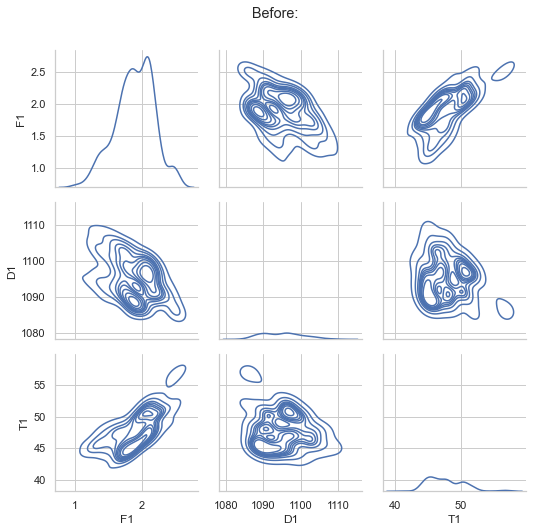

In [14]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

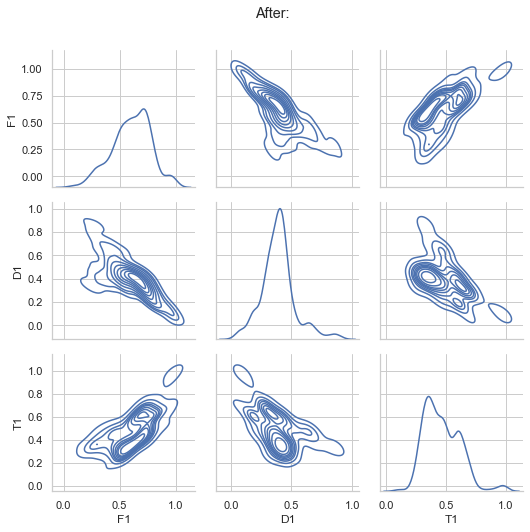

In [15]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

## Training the auto-encoder

In [16]:
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/bin/tensorboard", line 7, in <module>
    from tensorboard.main import run_main
  File "/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/lib/python3.8/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/lib/python3.8/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/lib/python3.8/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/lib/python3.8/site-packages/tensorboard/plugin_util.py", line 78, in <module>
    _MARKDOWN_STORE = _MarkdownStore()
  File "/Users/junxin

In [17]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                240       
                                                                 
 dense_1 (Dense)             (None, 16)                256       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 8)                 4

In [18]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [19]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
)

Epoch 1/100
47/47 [==============================] - 1s 5ms/step - loss: 0.3454 - acc: 0.0077 - val_loss: 0.2151 - val_acc: 0.0033
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1111 - acc: 0.0046 - val_loss: 0.0384 - val_acc: 0.0037
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0271 - acc: 0.5228 - val_loss: 0.0241 - val_acc: 0.8863
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0238 - acc: 0.8788 - val_loss: 0.0234 - val_acc: 0.8863
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0230 - acc: 0.8788 - val_loss: 0.0226 - val_acc: 0.8863
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0220 - acc: 0.8778 - val_loss: 0.0213 - val_acc: 0.8630
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0205 - acc: 0.8281 - val_loss: 0.0200 - val_acc: 0.8103
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0194 - a

## Reconstruction

In [20]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

108/216 [==============>...............] - ETA: 0s 

/Users/junxingli/opt/anaconda3/envs/XingPythonKernel/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


216/216 [==============================] - 0s 463us/step


In [34]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed- reconstructions, 2), axis=1)

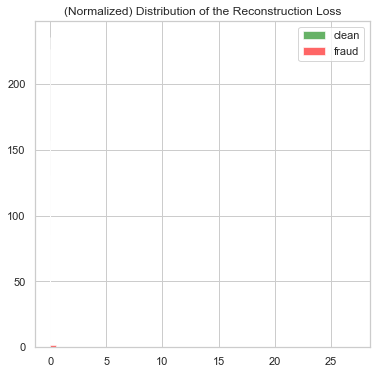

In [35]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()